In [1]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'HSP_Multi_Class_Classifier_Using_T5_Fine_Tuned_Model_on_data_3.0_HF.ipynb'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
!nvidia-smi

Sun May 26 10:36:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:21:00.0 Off |                    0 |
| N/A   50C    P0             208W / 300W |   5574MiB / 81920MiB |     57%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import wandb
wandb.init('19010c4e439d59bec411f7f9075c6e73ac7f5e13')    # Initialize wandb with your API key
wandb.login()   # Authenticate with wandb.ai

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find HSP_Multi_Class_Classifier_Using_T5_Fine_Tuned_Model_on_data_3.0_HF.ipynb.
wandb: Currently logged in as: yadav-sunil531984 (hsp_bits). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Import the Libraries

In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from transformers import DataCollatorWithPadding
import numpy as np
from peft import get_peft_model, LoraConfig, TaskType
import matplotlib.pyplot as plt

2024-05-26 10:36:06.910566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 10:36:07.562385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Datasets

Total Count of Samples =  4374


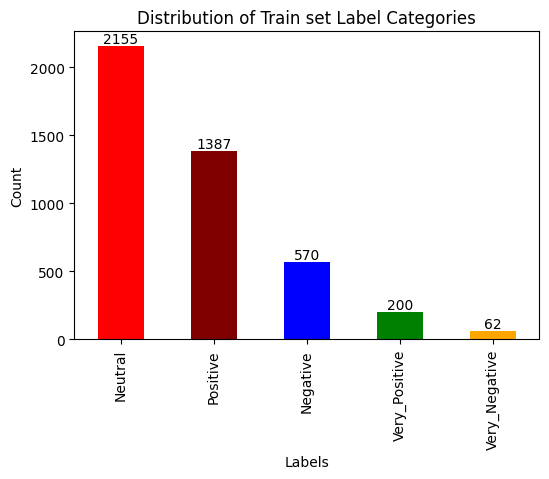

In [5]:
# Visualization of Class Labels Taining data
train_df=pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(train_df))
label_counts = train_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Train set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Total Count of Samples =  938


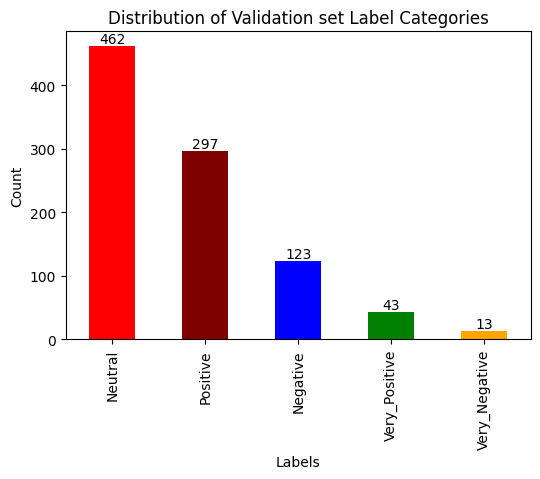

In [6]:
# Visualization of Class Labels Validation data
val_df = pd.read_csv('HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(val_df))
label_counts = val_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Validation set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Total Count of Samples =  938


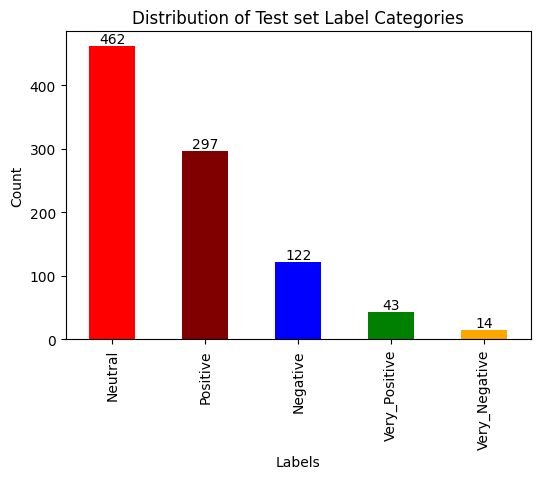

In [7]:
# Visualization of Class Labels Taining data
test_df=pd.read_csv('HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(test_df))
label_counts = test_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Test set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [8]:
train_df=pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4374 entries, 0 to 4373
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4374 non-null   int64 
 1   Text       4374 non-null   object
 2   Label_Id   4374 non-null   int64 
 3   Label      4374 non-null   object
 4   Label_Rev  4374 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 171.0+ KB


In [9]:
unique_values = train_df['Label_Rev'].unique()
unique_values 

array([0, 2, 1, 3, 4])

## Number of Characters

In [10]:
# Number of Characters
import pandas as pd

# Load the training data from the CSV file
train_df = pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')

# Calculate the maximum number of characters in the 'text' column
max_char = train_df['Text'].str.len().max()

# Calculate the maximum number of words in the 'text' column
max_words = train_df['Text'].str.split().str.len().max()

print(f"Maximum number of characters: {max_char}")
print(f"Maximum number of words: {max_words}")

Maximum number of characters: 1116
Maximum number of words: 97


## Define Tokenizer and checkpoints

In [11]:
# Define constants
MAX_LEN = 512
flant5_checkpoint = "google/flan-t5-base"

In [12]:
# Load the tokenizer
flant5_tokenizer = AutoTokenizer.from_pretrained(flant5_checkpoint, add_prefix_space=True)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Preprocessing Data

In [13]:
# Preprocessing function
def flant5_preprocessing_function(examples):
    return flant5_tokenizer(examples['Text'], truncation=True, max_length=MAX_LEN)

# Load each dataset file
train_dataset = load_dataset('csv', data_files='HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')['train']
val_dataset = load_dataset('csv', data_files='HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv')['train']
test_dataset = load_dataset('csv', data_files='HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv')['train']

# Define the columns to be removed
col_to_delete = ['id', 'Label_Id', 'Label']

# Apply preprocessing to each dataset separately
flant5_tokenized_train_dataset = train_dataset.map(flant5_preprocessing_function, batched=True, remove_columns=col_to_delete)
flant5_tokenized_val_dataset = val_dataset.map(flant5_preprocessing_function, batched=True, remove_columns=col_to_delete)
flant5_tokenized_test_dataset = test_dataset.map(flant5_preprocessing_function, batched=True, remove_columns=col_to_delete)

# Rename the 'Label_Rev' column to 'label' in each dataset
flant5_tokenized_train_dataset = flant5_tokenized_train_dataset.rename_column("Label_Rev", "label")
flant5_tokenized_val_dataset = flant5_tokenized_val_dataset.rename_column("Label_Rev", "label")
flant5_tokenized_test_dataset = flant5_tokenized_test_dataset.rename_column("Label_Rev", "label")

# Set format to 'torch' for all datasets
flant5_tokenized_train_dataset.set_format("torch")
flant5_tokenized_val_dataset.set_format("torch")
flant5_tokenized_test_dataset.set_format("torch")

# Data collator for padding a batch of examples to the maximum length seen in the batch
flant5_data_collator = DataCollatorWithPadding(tokenizer=flant5_tokenizer)

# Load Pretrained Model for Sequence Classification
flant5_model = AutoModelForSequenceClassification.from_pretrained(flant5_checkpoint, num_labels=5)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## LoRa setup 

In [14]:
# LoRa setup for Flan T5 classifier
flant5_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=4, lora_alpha=16, lora_dropout=0.1, bias="none"
)
flant5_model = get_peft_model(flant5_model, flant5_peft_config)
flant5_model.print_trainable_parameters()

# Ensure all model parameters require gradients
for param in flant5_model.parameters():
    param.requires_grad = True

trainable params: 442,368 || all params: 223,940,357 || trainable%: 0.19753831150675535


## Setup the trainer

### Evaluation Metric

In [15]:
# Evaluation Metric
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Ensure logits is a 2D numpy array
    if isinstance(logits, tuple):
        logits = logits[0]  # Extract the logits from a tuple if necessary
    # Reshape logits if needed
    if len(logits.shape) > 2:
        logits = logits.reshape(-1, logits.shape[-1])
    # Compute predictions
    predictions = np.argmax(logits, axis=-1)
    # Calculate metrics
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "accuracy": accuracy
    }

### Custom Trainer for Weighted Loss

In [16]:
# Custom Trainer for Loss
class CELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Ensure the model is in training mode
        model.train()
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


### Custom Callback to Store Losses Once per Epoch

In [17]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.epoch = 0

    def on_epoch_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Append the most recent training loss to the list
        for log in reversed(state.log_history):
            if 'loss' in log:
                self.training_losses.append(log['loss'])
                break  # Ensure we only add one training loss per epoch

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if len(self.training_losses) > len(self.validation_losses):
            # Append the most recent validation loss to the list
            for log in reversed(state.log_history):
                if 'eval_loss' in log:
                    self.validation_losses.append(log['eval_loss'])
                    break  # Ensure we only add one validation loss per epoch

In [18]:
loss_tracker_callback = LossTrackerCallback()

### Early Stopping Criteria

In [19]:
from transformers import EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

### Trainer setup

In [20]:
# Trainer setup
training_args = TrainingArguments(
    output_dir="flant5-large-lora-token-classification-hf",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb",
    fp16=False,
    gradient_checkpointing=True,
)


In [21]:
flant5_trainer = CELossTrainer(
    model=flant5_model,
    args=training_args,
    train_dataset=flant5_tokenized_train_dataset,
    eval_dataset=flant5_tokenized_val_dataset,
    data_collator=flant5_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_tracker_callback, early_stopping_callback]
)


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Model Training

In [22]:
# Start the training
train_result = flant5_trainer.train()

/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1-score,Accuracy
1,1.121300,1.005214,0.568699,0.572495,0.505148,0.572495
2,0.902500,1.021424,0.559463,0.578891,0.532951,0.578891
3,0.711900,1.158764,0.567653,0.581023,0.563335,0.581023
4,0.519300,1.365799,0.566810,0.582090,0.567360,0.582090


/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils

In [23]:
print(train_result)

TrainOutput(global_step=2188, training_loss=0.7840732595384448, metrics={'train_runtime': 625.8516, 'train_samples_per_second': 139.778, 'train_steps_per_second': 17.48, 'total_flos': 1556163040268640.0, 'train_loss': 0.7840732595384448, 'epoch': 4.0})


In [24]:
eval_result = flant5_trainer.evaluate()
print(eval_result)

/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


{'eval_loss': 1.344902753829956, 'eval_precision': 0.5763654510966472, 'eval_recall': 0.5852878464818764, 'eval_f1-score': 0.5697694146157222, 'eval_accuracy': 0.5852878464818764, 'eval_runtime': 5.1115, 'eval_samples_per_second': 183.509, 'eval_steps_per_second': 23.085, 'epoch': 4.0}


/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Analysis of Loss function and Evaluation of Trained Model

In [25]:
# Access the losses
training_losses = loss_tracker_callback.training_losses
validation_losses = loss_tracker_callback.validation_losses

print("Training Losses: ", training_losses)
print("Validation Losses: ", validation_losses)

Training Losses:  [1.1213, 0.9025, 0.7119, 0.5193]
Validation Losses:  [1.0052138566970825, 1.0214236974716187, 1.1587635278701782, 1.365798830986023]


In [26]:
print(len(training_losses ))
print(len(validation_losses ))

4
4


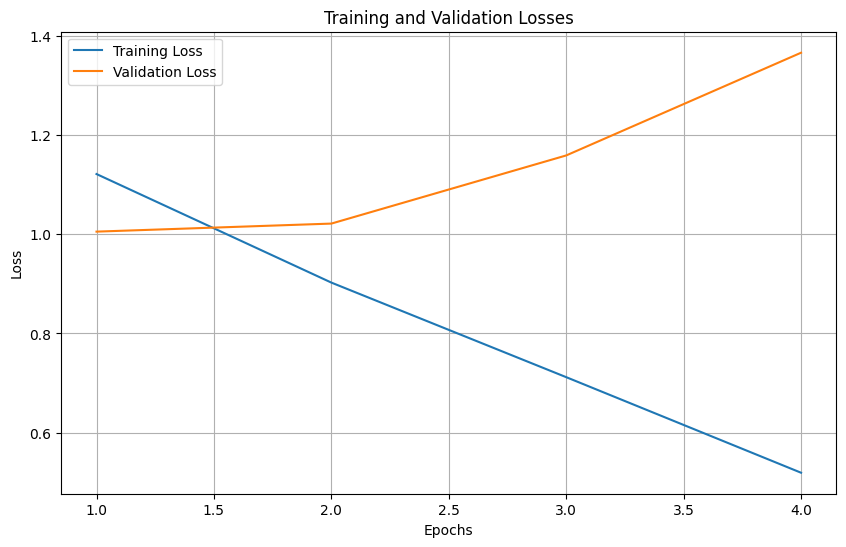

In [27]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation on Validation Datasets

In [28]:
# Perform prediction on the test dataset
predictions = flant5_trainer.predict(flant5_tokenized_val_dataset)

# Check the format of predictions
#print(predictions)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions[0], axis=1)

# Extract original test data
test_data = pd.read_csv('HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv')

# Add predicted labels to the test data
test_data['Predicted_Label'] = predicted_labels

# Save the dataframe to a new CSV file
test_data.to_csv('HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv', index=False)

/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [29]:
df = pd.read_csv('HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv')
df.head()

,id,Text,Label_Id,Label,Label_Rev,Predicted_Label
0,3370,Zakhme dill dikhaye gey\nHaal e gham sunaye ge...,3,Neutral,2,1
1,4731,Always reassuring to know that as an ace perso...,3,Neutral,2,2
2,3283,"happy birthday to Rin Natsume, she’s a trans l...",1,Very_Positive,0,1
3,4991,William Gay in at free safety with the first-t...,3,Neutral,2,2
4,2146,seeing people say that being bi isn't real/doe...,3,Neutral,2,1


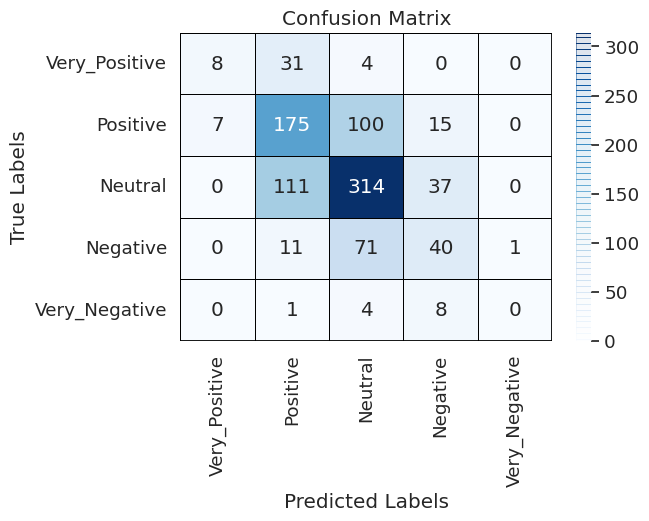

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file containing text data
df = pd.read_csv("HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv")

label_mapping = {0: "Very_Positive", 1: "Positive", 2: "Neutral", 3: "Negative", 4: "Very_Negative"}

# Generate the confusion matrix
confusion = confusion_matrix(df["Label_Rev"], df["Predicted_Label"])

# Create a heatmap of the confusion matrix with class labels
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),
                 linewidths=.5, linecolor='black', cbar_kws={'drawedges': True})  # Add cbar_kws parameter

# Add explicit border lines
ax.add_artist(plt.Line2D([0, len(label_mapping)], [len(label_mapping), len(label_mapping)], color='black', linewidth=2))
ax.add_artist(plt.Line2D([len(label_mapping), len(label_mapping)], [0, len(label_mapping)], color='black', linewidth=2))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Generate the classification report
classification_rep = classification_report(df["Label_Rev"], df["Predicted_Label"], target_names=list(label_mapping.values()))
print("Classification Report:\n", classification_rep)

Classification Report:
                precision    recall  f1-score   support

Very_Positive       0.53      0.19      0.28        43
     Positive       0.53      0.59      0.56       297
      Neutral       0.64      0.68      0.66       462
     Negative       0.40      0.33      0.36       123
Very_Negative       0.00      0.00      0.00        13

     accuracy                           0.57       938
    macro avg       0.42      0.36      0.37       938
 weighted avg       0.56      0.57      0.56       938



## Model Evaluation on Test Datasets

In [32]:
# Perform prediction on the test dataset
predictions = flant5_trainer.predict(flant5_tokenized_test_dataset)

# Check the format of predictions
#print(predictions)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions[0], axis=1)

# Extract original test data
test_data = pd.read_csv('HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv')

# Add predicted labels to the test data
test_data['Predicted_Label'] = predicted_labels

# Save the dataframe to a new CSV file
test_data.to_csv('HSP_Test_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv', index=False)

/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
df = pd.read_csv('HSP_Test_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv')
df.head()

,id,Text,Label_Id,Label,Label_Rev,Predicted_Label
0,4298,Being asexual in the month of june is very har...,2,Positive,1,2
1,2329,full fucking offense but cis people have no ri...,3,Neutral,2,2
2,537,"“if you're black, if you're white, if you're g...",1,Very_Positive,0,0
3,3218,It's a serious issue that i have to look for l...,2,Positive,1,2
4,644,"Have come out (again, still, constantly) to pe...",2,Positive,1,1


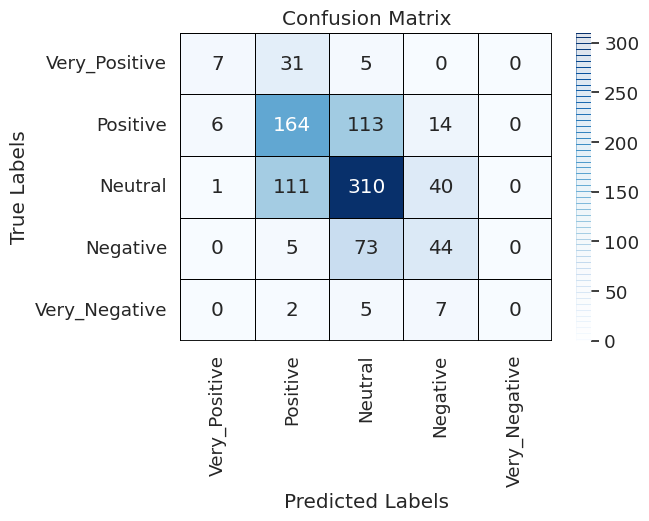

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file containing text data
df = pd.read_csv("HSP_Test_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv")

label_mapping = {0: "Very_Positive", 1: "Positive", 2: "Neutral", 3: "Negative", 4: "Very_Negative"}

# Generate the confusion matrix
confusion = confusion_matrix(df["Label_Rev"], df["Predicted_Label"])

# Create a heatmap of the confusion matrix with class labels
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),
                 linewidths=.5, linecolor='black', cbar_kws={'drawedges': True})  # Add cbar_kws parameter

# Add explicit border lines
ax.add_artist(plt.Line2D([0, len(label_mapping)], [len(label_mapping), len(label_mapping)], color='black', linewidth=2))
ax.add_artist(plt.Line2D([len(label_mapping), len(label_mapping)], [0, len(label_mapping)], color='black', linewidth=2))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Generate the classification report
classification_rep = classification_report(df["Label_Rev"], df["Predicted_Label"], target_names=list(label_mapping.values()))
print("Classification Report:\n", classification_rep)

Classification Report:
                precision    recall  f1-score   support

Very_Positive       0.50      0.16      0.25        43
     Positive       0.52      0.55      0.54       297
      Neutral       0.61      0.67      0.64       462
     Negative       0.42      0.36      0.39       122
Very_Negative       0.00      0.00      0.00        14

     accuracy                           0.56       938
    macro avg       0.41      0.35      0.36       938
 weighted avg       0.55      0.56      0.55       938



/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## General Inferencing

In [44]:
import torch
from torch.nn.functional import softmax

def prepare_input(text):
    inputs = flant5_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return {key: tensor.to(flant5_model.device) for key, tensor in inputs.items()}

def predict(text):
    flant5_model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = flant5_model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

In [45]:
# Example usage
text = "India is My Country"
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

Predicted class index: 1


In [46]:
# Example usage
text = "I hate you, You are worst gay."
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

Predicted class index: 3


In [ ]:
# Example usage
text = "LGBTQ+ people are also human, Give respect to save humanity."
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

In [ ]:
text = "I hate you, You are worst gay."
text = "LGBTQ+ people are also human, Give respect to save humanity."

In [1]:
!nvidia-smi

Sun May 26 11:27:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:21:00.0 Off |                    0 |
| N/A   31C    P0              67W / 300W |  43130MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--